# IceCube Data Visualization Test

이 노트북은 GENESIS 프로젝트의 데이터를 로드하고 시각화하는 테스트를 위한 것입니다.

## 목차
1. [환경 설정 및 라이브러리 임포트](#1-환경-설정-및-라이브러리-임포트)
2. [데이터 로딩](#2-데이터-로딩)
3. [기본 데이터 탐색](#3-기본-데이터-탐색)
4. [3D 이벤트 시각화](#4-3d-이벤트-시각화)
5. [히스토그램 분석](#5-히스토그램-분석)
6. [NPZ 파일 시각화](#6-npz-파일-시각화)


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
# 필요한 라이브러리 임포트
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path
import torch

# Git repository 루트 자동 감지
def get_git_root():
    """Git repository 루트를 찾는 함수"""
    import subprocess
    try:
        result = subprocess.run(['git', 'rev-parse', '--show-toplevel'], 
                              capture_output=True, text=True, check=True)
        return result.stdout.strip()
    except (subprocess.CalledProcessError, FileNotFoundError):
        # Git이 없거나 Git repository가 아닌 경우, 현재 디렉토리 반환
        return str(Path.cwd())

# Git repository 루트 설정
git_root = get_git_root()
project_root = Path(git_root)
sys.path.insert(0, str(project_root))

print(f"🔧 Git repository 루트: {git_root}")
print(f"📁 프로젝트 루트: {project_root}")

# GENESIS 유틸리티 임포트
from utils.denormalization import denormalize_signal, denormalize_label
from utils.fast_3d_plot import plot_event_3d
from utils.h5_hist import plot_hist_pair
from utils.npz_show_event import show_event
from utils.visualization import EventVisualizer

# 설정
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
print("✅ 라이브러리 임포트 완료!")


🔧 Git repository 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
📁 프로젝트 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
✅ 라이브러리 임포트 완료!


## 2. 데이터 로딩


In [2]:
# 설정 파일 로드
from config import load_config_from_file

config_path = project_root / "configs" / "default.yaml"
detector_csv = project_root / "configs" / "detector_geometry.csv"

try:
    config = load_config_from_file(str(config_path))
    print("✅ 설정 파일 로드 성공!")
    print(f"📊 데이터셋 경로: {config.data.h5_path}")
    print(f"🔄 시간 변환: {config.data.time_transform}")
    print(f"📏 시퀀스 길이: {config.model.seq_len}")
except Exception as e:
    print(f"❌ 설정 파일 로드 실패: {e}")
    config = None

# 검출기 지오메트리 로드
try:
    geometry_df = pd.read_csv(detector_csv)
    geometry = geometry_df[['x', 'y', 'z']].values
    print(f"✅ 검출기 지오메트리 로드 성공! Shape: {geometry.shape}")
    print(f"📍 X 범위: [{geometry[:, 0].min():.1f}, {geometry[:, 0].max():.1f}]")
    print(f"📍 Y 범위: [{geometry[:, 1].min():.1f}, {geometry[:, 1].max():.1f}]")
    print(f"📍 Z 범위: [{geometry[:, 2].min():.1f}, {geometry[:, 2].max():.1f}]")
except Exception as e:
    print(f"❌ 검출기 지오메트리 로드 실패: {e}")
    geometry = None


✅ 설정 파일 로드 성공!
📊 데이터셋 경로: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/GENESIS-data/22644_0921_time_shift.h5
🔄 시간 변환: ln
📏 시퀀스 길이: 5160
✅ 검출기 지오메트리 로드 성공! Shape: (5160, 3)
📍 X 범위: [-570.9, 576.4]
📍 Y 범위: [-521.1, 509.5]
📍 Z 범위: [-512.8, 524.6]


In [3]:
# HDF5 데이터 로드
if config:
    h5_path = Path(config.data.h5_path)
    print(f"🔍 HDF5 파일 경로 확인:")
    print(f"   설정된 경로: {config.data.h5_path}")
    print(f"   Git repository 루트: {project_root}")
    print(f"   절대 경로: {h5_path.resolve()}")
    print(f"   파일 존재 여부: {h5_path.exists()}")
    
    if h5_path.exists():
        try:
            with h5py.File(str(h5_path), 'r') as f:
                print("\n📁 HDF5 파일 구조:")
                for key in f.keys():
                    print(f"  - {key}: {f[key].shape}")
                
                # 첫 번째 이벤트 로드
                if 'input' in f:
                    sample_input = f['input'][0]  # (2, 5160)
                    print(f"\n✅ 샘플 입력 데이터 로드: {sample_input.shape}")
                    print(f"  - Charge 범위: [{sample_input[0].min():.3f}, {sample_input[0].max():.3f}]")
                    print(f"  - Time 범위: [{sample_input[1].min():.3f}, {sample_input[1].max():.3f}]")
                
                if 'label' in f:
                    sample_label = f['label'][0]  # (6,)
                    print(f"✅ 샘플 라벨 데이터 로드: {sample_label.shape}")
                    print(f"  - Energy: {sample_label[0]:.3f}")
                    print(f"  - Zenith: {sample_label[1]:.3f}")
                    print(f"  - Azimuth: {sample_label[2]:.3f}")
                    print(f"  - Position: ({sample_label[3]:.1f}, {sample_label[4]:.1f}, {sample_label[5]:.1f})")
                    
            print("\n🎉 HDF5 파일 로드 성공!")
        except Exception as e:
            print(f"\n❌ HDF5 데이터 로드 실패: {e}")
            sample_input = None
            sample_label = None
    else:
        print("\n⚠️ HDF5 데이터 파일을 찾을 수 없습니다. 더미 데이터를 생성합니다.")
        # 더미 데이터 생성
        sample_input = np.random.exponential(0.1, (2, 5160))
        sample_input[1] = np.random.normal(500, 100, 5160)  # Time
        sample_label = np.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])  # [energy, zenith, azimuth, x, y, z]
        print("✅ 더미 데이터 생성 완료!")
else:
    print("\n⚠️ 설정 파일을 로드할 수 없습니다. 더미 데이터를 생성합니다.")
    # 더미 데이터 생성
    sample_input = np.random.exponential(0.1, (2, 5160))
    sample_input[1] = np.random.normal(500, 100, 5160)  # Time
    sample_label = np.array([1.0, 0.5, 0.0, 0.0, 0.0, 0.0])  # [energy, zenith, azimuth, x, y, z]
    print("✅ 더미 데이터 생성 완료!")


🔍 HDF5 파일 경로 확인:
   설정된 경로: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/GENESIS-data/22644_0921_time_shift.h5
   Git repository 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
   절대 경로: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/GENESIS-data/22644_0921_time_shift.h5
   파일 존재 여부: True

📁 HDF5 파일 구조:
  - info: (178056, 9)
  - input: (178056, 2, 5160)
  - label: (178056, 6)
  - xpmt: (5160,)
  - ypmt: (5160,)
  - zpmt: (5160,)

✅ 샘플 입력 데이터 로드: (2, 5160)
  - Charge 범위: [0.000, 102.000]
  - Time 범위: [0.000, 3339.000]
✅ 샘플 라벨 데이터 로드: (6,)
  - Energy: 66469596.000
  - Zenith: 2.695
  - Azimuth: 2.937
  - Position: (-526.6, -15.6, 37.4)

🎉 HDF5 파일 로드 성공!


## 3. 기본 데이터 탐색


📊 데이터 통계 분석
🔋 Charge (NPE) 통계:
  - 총 PMT 수: 5160
  - 0이 아닌 PMT 수: 156 (3.0%)
  - 평균: 0.3789
  - 중앙값: 0.0000
  - 표준편차: 4.1534
  - 범위: [0.0000, 102.0000]

⏰ Time 통계:
  - 유한한 값의 수: 5160 (100.0%)
  - 평균: 38.47 ns
  - 중앙값: 0.00 ns
  - 표준편차: 252.84 ns
  - 범위: [0.00, 3339.00] ns


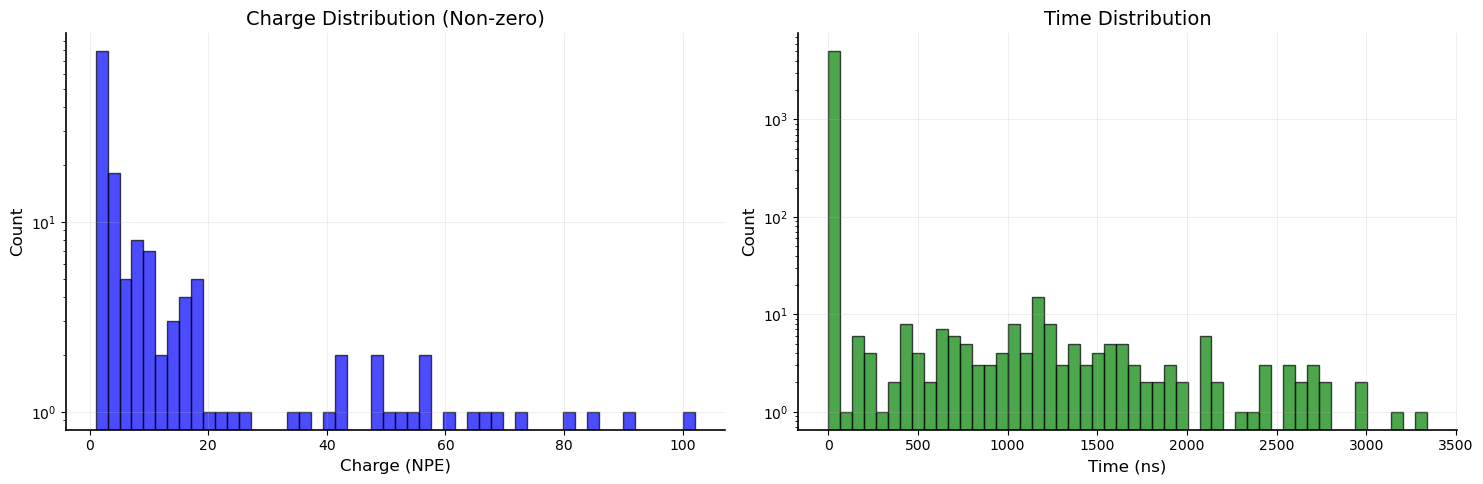

In [4]:
# 기본 통계 분석
if sample_input is not None:
    charge_data = sample_input[0]
    time_data = sample_input[1]
    
    print("📊 데이터 통계 분석")
    print("=" * 50)
    
    # Charge 통계
    print("🔋 Charge (NPE) 통계:")
    print(f"  - 총 PMT 수: {len(charge_data)}")
    print(f"  - 0이 아닌 PMT 수: {np.sum(charge_data > 0)} ({100*np.sum(charge_data > 0)/len(charge_data):.1f}%)")
    print(f"  - 평균: {np.mean(charge_data):.4f}")
    print(f"  - 중앙값: {np.median(charge_data):.4f}")
    print(f"  - 표준편차: {np.std(charge_data):.4f}")
    print(f"  - 범위: [{np.min(charge_data):.4f}, {np.max(charge_data):.4f}]")
    
    print("\n⏰ Time 통계:")
    finite_time = time_data[np.isfinite(time_data)]
    print(f"  - 유한한 값의 수: {len(finite_time)} ({100*len(finite_time)/len(time_data):.1f}%)")
    if len(finite_time) > 0:
        print(f"  - 평균: {np.mean(finite_time):.2f} ns")
        print(f"  - 중앙값: {np.median(finite_time):.2f} ns")
        print(f"  - 표준편차: {np.std(finite_time):.2f} ns")
        print(f"  - 범위: [{np.min(finite_time):.2f}, {np.max(finite_time):.2f}] ns")
    
    # 간단한 히스토그램
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Charge 히스토그램
    charge_nonzero = charge_data[charge_data > 0]
    if len(charge_nonzero) > 0:
        ax1.hist(charge_nonzero, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax1.set_xlabel('Charge (NPE)')
        ax1.set_ylabel('Count')
        ax1.set_title('Charge Distribution (Non-zero)')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
    
    # Time 히스토그램
    if len(finite_time) > 0:
        ax2.hist(finite_time, bins=50, alpha=0.7, color='green', edgecolor='black')
        ax2.set_xlabel('Time (ns)')
        ax2.set_ylabel('Count')
        ax2.set_title('Time Distribution')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ 샘플 데이터가 없습니다.")


## 4. 3D 이벤트 시각화


🎨 3D 이벤트 시각화 생성 중...
🎨 Creating fast 3D plot...
   Plot type: both
   PMTs: 5160
   Energy: 66469596.000, Zenith: 2.695, Azimuth: 2.937
   📊 NPE: 156 PMTs, range=[1.000, 102.000]
   📊 Time: 155 PMTs, range=[127.0, 3339.0] ns
✅ Fast 3D plot completed in 0.150 seconds


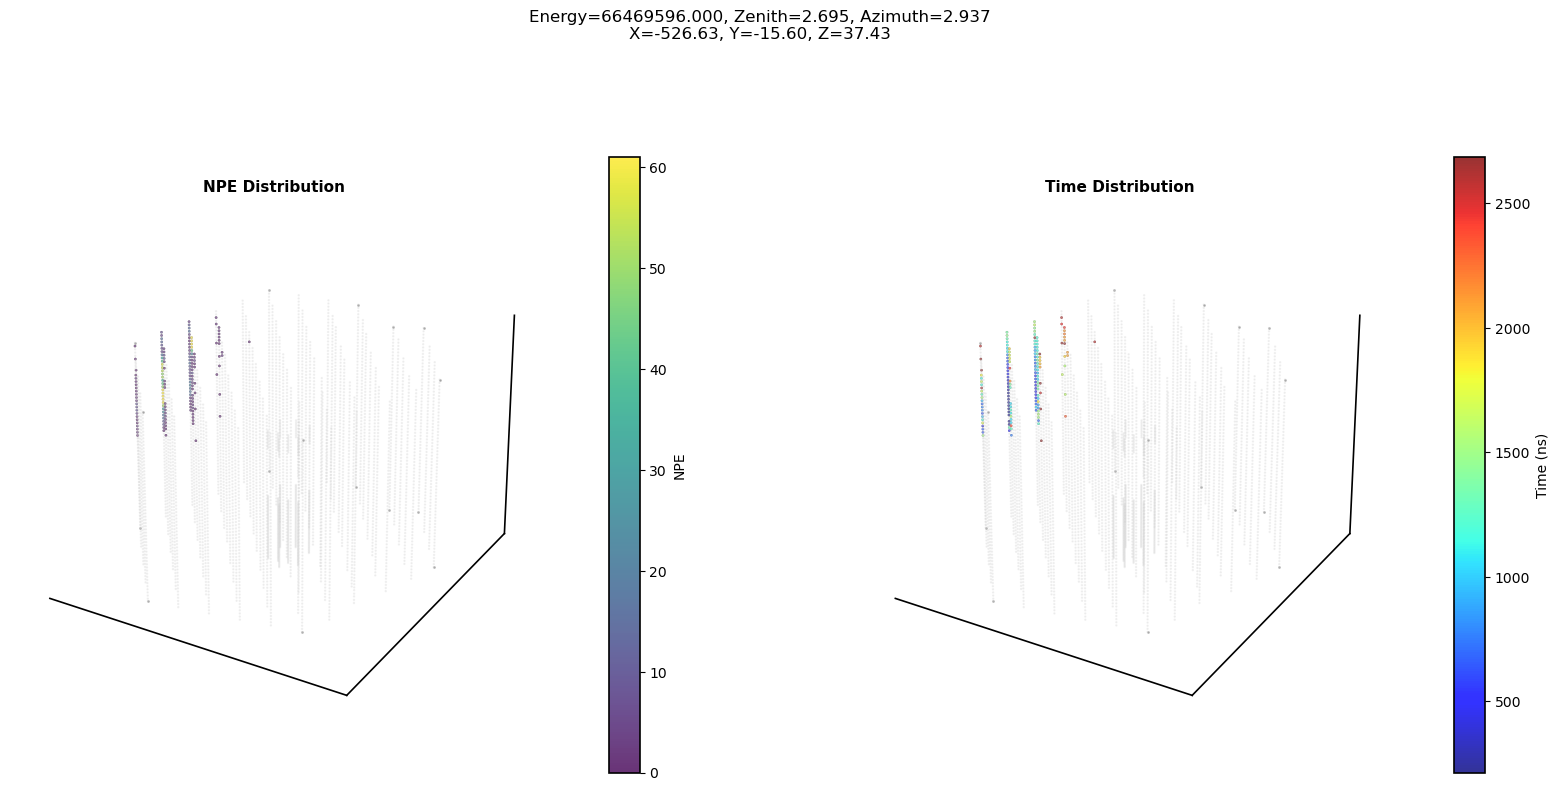

✅ 3D 시각화 완료!


In [5]:
# 3D 이벤트 시각화 (fast_3d_plot 사용)
if sample_input is not None and geometry is not None and sample_label is not None:
    print("🎨 3D 이벤트 시각화 생성 중...")
    
    # fast_3d_plot을 사용한 시각화
    fig, axes = plot_event_3d(
        charge_data=sample_input[0],
        time_data=sample_input[1], 
        geometry=geometry,
        labels=sample_label,
        output_path=None,  # 노트북에서 표시
        plot_type="both",  # NPE와 Time 모두 표시
        figure_size=(20, 10),
        show_detector_hull=True,
        show_background=True,
        sphere_size=3.0,
        alpha=0.8
    )
    
    plt.show()
    print("✅ 3D 시각화 완료!")
else:
    print("❌ 3D 시각화를 위한 데이터가 부족합니다.")
    print(f"  - sample_input: {sample_input is not None}")
    print(f"  - geometry: {geometry is not None}")
    print(f"  - sample_label: {sample_label is not None}")


## 5. 히스토그램 분석


In [7]:
# h5_hist를 사용한 아름다운 히스토그램 생성
if config and Path(config.data.h5_path).exists():
    print("📊 HDF5 데이터에서 히스토그램 생성 중...")
    
    try:
        # h5_hist를 사용한 히스토그램 생성
        plot_hist_pair(
            h5_path=config.data.h5_path,
            bins=1000,
            chunk=1024,
            out_prefix=str(project_root / "testing" / "hist_analysis"),
            logy=True,
            log_time_transform="ln",
            exclude_zero=True,
            style="modern",
            figsize=(16, 8)
        )
        print("✅ 히스토그램 생성 완료! testing/ 폴더를 확인하세요.")
        
    except Exception as e:
        print(f"❌ 히스토그램 생성 실패: {e}")
        
else:
    print("⚠️ HDF5 파일이 없어서 더미 데이터로 히스토그램을 생성합니다.")
    
    # 더미 데이터로 히스토그램 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Charge 히스토그램 (더미 데이터)
    charge_dummy = np.random.exponential(0.1, 10000)
    charge_dummy = charge_dummy[charge_dummy > 0]  # 0 제외
    
    ax1.hist(charge_dummy, bins=50, alpha=0.7, color='#2E86AB', edgecolor='#1A5F7A')
    ax1.set_xlabel('Charge (NPE)')
    ax1.set_ylabel('Count (log scale)')
    ax1.set_title('Charge Distribution (Dummy Data)')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Time 히스토그램 (더미 데이터)
    time_dummy = np.random.normal(500, 100, 10000)
    time_dummy = time_dummy[time_dummy > 0]  # 양수만
    
    ax2.hist(time_dummy, bins=50, alpha=0.7, color='#A23B72', edgecolor='#7D2A5A')
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Count (log scale)')
    ax2.set_title('Time Distribution (Dummy Data)')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("✅ 더미 데이터 히스토그램 생성 완료!")


📊 HDF5 데이터에서 히스토그램 생성 중...
🔄 Time range transformation:
   Original: [0.0, 4007.0]
   ln transformed: [-23.026, 8.296]

🎨 Style: Modern
📊 Charge Statistics (Non-zero only):
  Count: 249,716
  Range: [1.000, 197.000]
  Mean ± Std: 15.764 ± 27.125
  Median: 4.000
  Percentiles: P10=1.000, P90=52.000
  Zeros: 871,695,019 (95.4%)

⏱️  Time Statistics (Non-zero only) [ln transformed]:
  Count: 248,687
  Range: [0.000, 9.747]
  Mean ± Std: 7.536 ± 0.817
  Median: 7.703
  Percentiles: P10=6.571, P90=8.326
  Zeros: 871,874,296 (95.4%)
  Log Transform: ln
✅ 히스토그램 생성 완료! testing/ 폴더를 확인하세요.


## 6. NPZ 파일 시각화


💾 NPZ 파일 생성 중...
✅ NPZ 파일 생성 완료: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/testing/sample_event.npz
🎨 NPZ 파일 시각화 중...
[ 6.6469596e+07  2.6949327e+00  2.9374740e+00 -5.2663000e+02
 -1.5600000e+01  3.7430000e+01]
📊 Rendered 155/155 PMTs


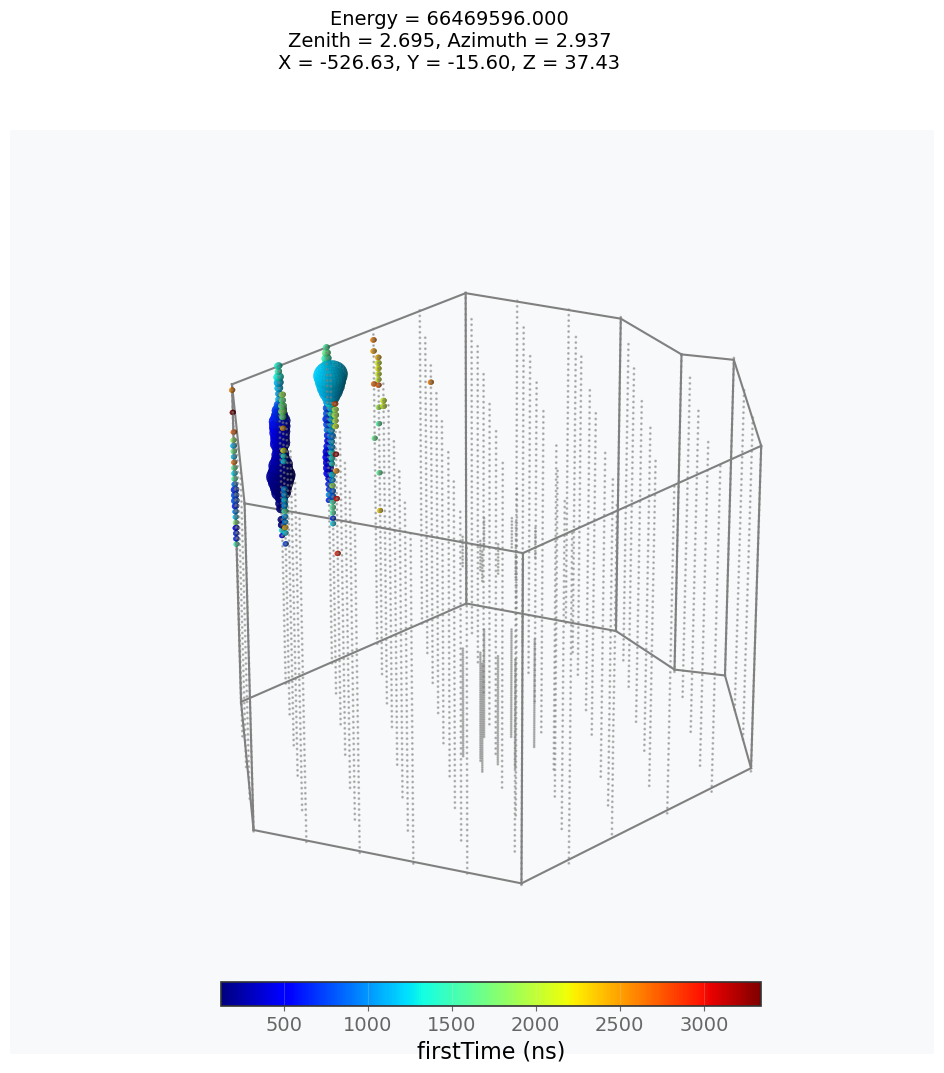

✅ NPZ 시각화 완료!


In [8]:
# NPZ 파일 생성 및 시각화
if sample_input is not None and sample_label is not None:
    print("💾 NPZ 파일 생성 중...")
    
    # NPZ 파일 생성
    npz_path = str(project_root / "testing" / "sample_event.npz")
    np.savez(npz_path, 
             input=sample_input,
             label=sample_label,
             info=sample_label)  # info는 label과 동일하게 설정
    
    print(f"✅ NPZ 파일 생성 완료: {npz_path}")
    
    # NPZ 파일 시각화
    if geometry is not None:
        print("🎨 NPZ 파일 시각화 중...")
        
        try:
            fig, ax = show_event(
                npz_path=npz_path,
                detector_csv=str(detector_csv),
                out_path=str(project_root / "testing" / "npz_visualization.png"),
                sphere_res=(30, 15),
                base_radius=6.0,
                radius_scale=0.3,
                figure_size=(18, 12),
                separate_plots=False
            )
            plt.show()
            print("✅ NPZ 시각화 완료!")
            
        except Exception as e:
            print(f"❌ NPZ 시각화 실패: {e}")
    else:
        print("❌ 검출기 지오메트리가 없어서 NPZ 시각화를 할 수 없습니다.")
        
else:
    print("❌ NPZ 파일 생성을 위한 데이터가 부족합니다.")


## 7. 정규화/비정규화 테스트


🔄 정규화/비정규화 테스트...
✅ 신호 비정규화 완료!
  - 원본 범위: Charge [0.000, 102.000]
  - 비정규화 범위: Charge [0.000, 20400.000]
✅ 라벨 비정규화 완료!
  - 원본 Energy: 66469596.000
  - 비정규화 Energy: 6646959569895424.000
🎨 비정규화된 데이터로 시각화...
🎨 Creating fast 3D plot...
   Plot type: both
   PMTs: 5160
   Energy: 6646959569895424.000, Zenith: 8.466, Azimuth: 18.457
   📊 NPE: 156 PMTs, range=[200.000, 20400.000]
   📊 Time: 155 PMTs, range=[485165184.0, 485165184.0] ns
📁 Saved: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/testing/denormalized_visualization.png
✅ Fast 3D plot completed in 0.485 seconds


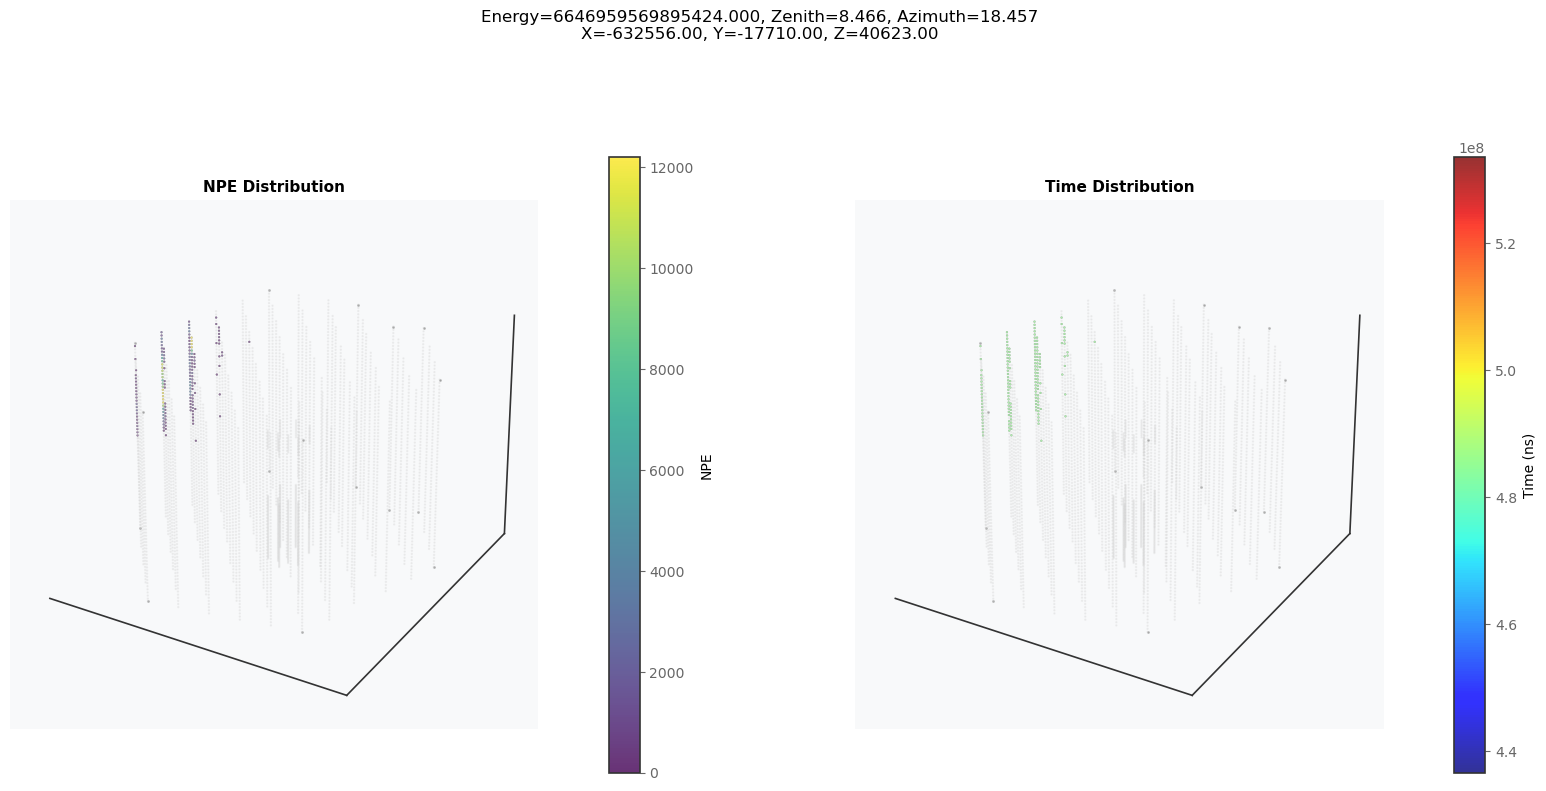

✅ 비정규화 시각화 완료!


In [9]:
# 정규화/비정규화 테스트
if config and sample_input is not None:
    print("🔄 정규화/비정규화 테스트...")
    
    try:
        # 정규화된 데이터를 원래 스케일로 변환
        x_sig_original = denormalize_signal(
            torch.tensor(sample_input),
            affine_offsets=tuple(config.data.affine_offsets),
            affine_scales=tuple(config.data.affine_scales),
            time_transform=config.data.time_transform,
            channels="signal"
        )
        
        print("✅ 신호 비정규화 완료!")
        print(f"  - 원본 범위: Charge [{sample_input[0].min():.3f}, {sample_input[0].max():.3f}]")
        print(f"  - 비정규화 범위: Charge [{x_sig_original[0].min():.3f}, {x_sig_original[0].max():.3f}]")
        
        # 라벨 비정규화
        if sample_label is not None:
            label_original = denormalize_label(
                torch.tensor(sample_label),
                label_offsets=tuple(config.data.label_offsets),
                label_scales=tuple(config.data.label_scales)
            )
            
            print("✅ 라벨 비정규화 완료!")
            print(f"  - 원본 Energy: {sample_label[0]:.3f}")
            print(f"  - 비정규화 Energy: {label_original[0]:.3f}")
            
            # 비정규화된 데이터로 시각화
            if geometry is not None:
                print("🎨 비정규화된 데이터로 시각화...")
                fig, axes = plot_event_3d(
                    charge_data=x_sig_original[0].numpy(),
                    time_data=x_sig_original[1].numpy(),
                    geometry=geometry,
                    labels=label_original.numpy(),
                    output_path=str(project_root / "testing" / "denormalized_visualization.png"),
                    plot_type="both",
                    figure_size=(20, 10)
                )
                plt.show()
                print("✅ 비정규화 시각화 완료!")
        
    except Exception as e:
        print(f"❌ 정규화/비정규화 테스트 실패: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ 정규화/비정규화 테스트를 위한 설정이나 데이터가 부족합니다.")


## 8. 요약 및 다음 단계

이 노트북을 통해 다음을 테스트했습니다:

### ✅ 완료된 테스트
1. **환경 설정**: Git repository 루트 자동 감지 및 라이브러리 임포트
2. **데이터 로딩**: 설정 파일, 검출기 지오메트리, HDF5 데이터
3. **기본 탐색**: 데이터 통계 분석 및 히스토그램
4. **3D 시각화**: fast_3d_plot을 사용한 이벤트 시각화
5. **히스토그램 분석**: h5_hist를 사용한 아름다운 히스토그램
6. **NPZ 시각화**: NPZ 파일 생성 및 시각화
7. **정규화/비정규화**: 데이터 변환 테스트

### 📁 생성된 파일들
- `{project_root}/testing/sample_event.npz`: 샘플 이벤트 NPZ 파일
- `{project_root}/testing/npz_visualization.png`: NPZ 시각화 이미지
- `{project_root}/testing/denormalized_visualization.png`: 비정규화 시각화 이미지
- `{project_root}/testing/hist_analysis_*.png`: 히스토그램 분석 이미지들

### 🚀 다음 단계 제안
1. **실제 데이터로 테스트**: HDF5 파일이 있다면 실제 데이터로 테스트
2. **다양한 이벤트 시각화**: 여러 이벤트를 비교 시각화
3. **커스텀 시각화**: 특정 요구사항에 맞는 시각화 개발
4. **성능 최적화**: 대용량 데이터 처리 최적화
